## MAML, RL$^2$ approach, PEARL paper implementations in TF 2.0


[**MAML: Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks**](https://arxiv.org/abs/1703.03400)

*Chelsea Finn, Pieter Abbeel, Sergey Levine*
> We propose an algorithm for meta-learning that is model-agnostic, in the sense that it is compatible with any model trained with gradient descent and applicable to a variety of different learning problems, including classification, regression, and reinforcement learning. The goal of meta-learning is to train a model on a variety of learning tasks, such that it can solve new learning tasks using only a small number of training samples. In our approach, the parameters of the model are explicitly trained such that a small number of gradient steps with a small amount of training data from a new task will produce good generalization performance on that task. In effect, our method trains the model to be easy to fine-tune. We demonstrate that this approach leads to state-of-the-art performance on two few-shot image classification benchmarks, produces good results on few-shot regression, and accelerates fine-tuning for policy gradient reinforcement learning with neural network policies.

---
[**RL$^2$: Fast Reinforcement Learning via Slow Reinforcement Learning**](https://arxiv.org/abs/1611.02779)

*Yan Duan, John Schulman, Xi Chen, Peter L. Bartlett, Ilya Sutskever, Pieter Abbeel* 

> Deep reinforcement learning (deep RL) has been successful in learning sophisticated behaviors automatically; however, the learning process requires a huge number of trials. In contrast, animals can learn new tasks in just a few trials, benefiting from their prior knowledge about the world. This paper seeks to bridge this gap. Rather than designing a "fast" reinforcement learning algorithm, we propose to represent it as a recurrent neural network (RNN) and learn it from data. In our proposed method, RL2, the algorithm is encoded in the weights of the RNN, which are learned slowly through a general-purpose ("slow") RL algorithm. The RNN receives all information a typical RL algorithm would receive, including observations, actions, rewards, and termination flags; and it retains its state across episodes in a given Markov Decision Process (MDP). The activations of the RNN store the state of the "fast" RL algorithm on the current (previously unseen) MDP. We evaluate RL2 experimentally on both small-scale and large-scale problems. On the small-scale side, we train it to solve randomly generated multi-arm bandit problems and finite MDPs. After RL2 is trained, its performance on new MDPs is close to human-designed algorithms with optimality guarantees. On the large-scale side, we test RL2 on a vision-based navigation task and show that it scales up to high-dimensional problems.
---
[**PEARL: Efficient Off-policy Meta-learning via Probabilistic Context Variables**](https://arxiv.org/abs/1903.08254)

*Kate Rakelly, Aurick Zhou, Deirdre Quillen, Chelsea Finn, Sergey Levine*

> Deep reinforcement learning algorithms require large amounts of experience to learn an individual task. While in principle meta-reinforcement learning (meta-RL) algorithms enable agents to learn new skills from small amounts of experience, several major challenges preclude their practicality. Current methods rely heavily on on-policy experience, limiting their sample efficiency. The also lack mechanisms to reason about task uncertainty when adapting to new tasks, limiting their effectiveness in sparse reward problems. In this paper, we address these challenges by developing an off-policy meta-RL algorithm that disentangles task inference and control. In our approach, we perform online probabilistic filtering of latent task variables to infer how to solve a new task from small amounts of experience. This probabilistic interpretation enables posterior sampling for structured and efficient exploration. We demonstrate how to integrate these task variables with off-policy RL algorithms to achieve both meta-training and adaptation efficiency. Our method outperforms prior algorithms in sample efficiency by 20-100X as well as in asymptotic performance on several meta-RL benchmarks.

Highly influenced by resources the following resources,
- https://github.com/mari-linhares/tensorflow-maml

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend

import time
import random


np.random.seed(42)


"tensorflow version", tf.__version__

('tensorflow version', '2.3.0')

### Sine wave 1D regression task
On this simple regression task all three methods will be evaluated. 

In [7]:
class SinusoidGenerator():
  ''' Sinusoid Generator
        
      p(T) is continuous, where the amplitude (a) varies within [0.1, 5.0]
      and the phase (b) varies within [0, π]. In the FOMAML paper the range 
      varies between varies within [0, 2π].
  '''
  def __init__(self, K=10, a=None, b=None, UL_b=np.pi):
    '''Amplitude a and phase b, upper limit of the phase UL_b'''
    self.a = a if a else np.random.uniform(0.1, 5.0)
    self.b = b if b else np.random.uniform(0, UL_b)

    self.K = K        
    self.sampled_points = None
    self.x = np.random.uniform(-5, 5, self.K)

  def f(self, x):
    '''Sinewave function'''
    return self.a * np.sin(x + self.b)

  def batch(self, x=None, generate_new=False):
    '''Returns a batch of size K.
    
    It also changes the sape of `x` to add a batch dimension to it.
    
    Args:
        x: Batch data, if given `y` is generated based on this data.
            Usually it is None. If None `self.x` is used.
        generate_new: Instead of using `x` argument the batch data is
            uniformly sampled.
    '''
    if x is None:
        if generate_new:
            x = np.random.uniform(-5, 5, self.K)
        else:
            x = self.x
    y = self.f(x)
    return x[:, None], y[:, None]
    
  def equally_spaced_samples(self, K=None):
    '''Returns `K` equally spaced samples.'''
    if K is None:
        K = self.K
    return self.batch(x=np.linspace(-5, 5, K))

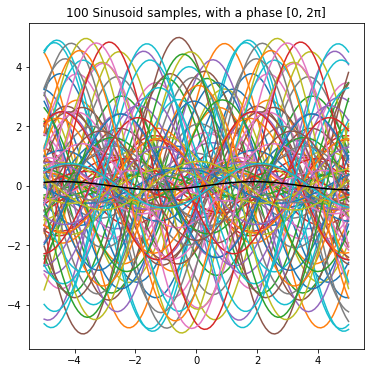

In [51]:
fig, ax = plt.subplots(figsize=(6, 6))
x_av, y_av = np.zeros((100, 1)), np.zeros((100, 1))

for _ in range(100):
    x, y = SinusoidGenerator(K=100, UL_b=2*np.pi).equally_spaced_samples()
    ax.plot(x, y)
    x_av = x
    y_av = y_av + y
    
plt.title("100 Sinusoid samples, with a phase [0, 2π]")
ax.plot(x_av, y_av/100, color='black', label='average')
plt.show()

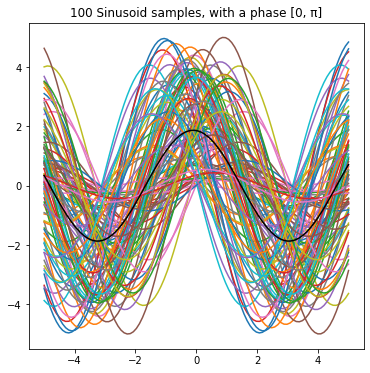

In [50]:
fig, ax = plt.subplots(figsize=(6, 6))
x_av, y_av = np.zeros((100, 1)), np.zeros((100, 1))

for _ in range(100):
    x, y = SinusoidGenerator(K=100).equally_spaced_samples()
    ax.plot(x, y)
    x_av, y_av = x, y_av + y
    
plt.title("100 Sinusoid samples, with a phase [0, π]")
ax.plot(x_av, y_av/100, color='black', label='average')
plt.show()

### Generate sinusoid datasets

In [25]:
def generate_dataset(K, train_size=20000, test_size=10):
    '''Generate train and test dataset.
    
    A dataset is composed of SinusoidGenerators that are able to provide
    a batch (`K`) elements at a time.
    '''
    def _generate_dataset(size):
        return [SinusoidGenerator(K=K) for _ in range(size)]
    return _generate_dataset(train_size), _generate_dataset(test_size) 

train_set, test_set = generate_dataset(K=10)

len(train_set), len(test_set)

(20000, 10)

#### Model definition


> *The regressor
is a neural network model with 2 hidden layers of size
40 with ReLU nonlinearities.*

In [57]:
# Dense layers as defined in the MAML paper
class SineModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [58]:
def loss_function(pred_y, y):
    '''Mean Squared Error'''
    return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))


def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)


def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model.forward(x)
    mse = loss_fn(y, logits)
    return mse, logits


def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

    
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss

Step 1000: loss = 3.7931617603035543, Time to run 1000 steps = 4.62 seconds
Step 2000: loss = 3.525940690101285, Time to run 1000 steps = 4.62 seconds
Step 3000: loss = 3.4631292900596824, Time to run 1000 steps = 4.73 seconds
Step 4000: loss = 3.420083080210283, Time to run 1000 steps = 4.59 seconds
Step 5000: loss = 3.3991562564234337, Time to run 1000 steps = 4.83 seconds
Step 6000: loss = 3.3386119867225124, Time to run 1000 steps = 4.72 seconds
Step 7000: loss = 3.2926387308296485, Time to run 1000 steps = 4.91 seconds
Step 8000: loss = 3.273739860881766, Time to run 1000 steps = 4.86 seconds
Step 9000: loss = 3.2551990612813446, Time to run 1000 steps = 4.88 seconds
Step 10000: loss = 3.2322967515925245, Time to run 1000 steps = 4.98 seconds
Step 11000: loss = 3.222491899651504, Time to run 1000 steps = 6.30 seconds
Step 12000: loss = 3.1987030080933176, Time to run 1000 steps = 5.88 seconds
Step 13000: loss = 3.188537899615788, Time to run 1000 steps = 5.14 seconds
Step 14000: l

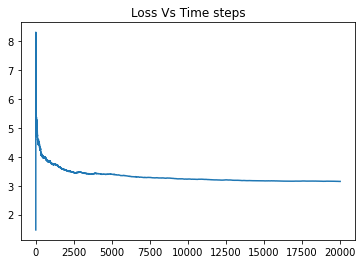

In [59]:
# Naive approach to training on different tasks,
def train_model(dataset, epochs=1, lr=0.001, log_steps=1000):
    model = SineModel()
    optimizer = keras.optimizers.Adam(learning_rate=lr)

    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()
        for i, sinusoid_generator in enumerate(dataset):
            x, y = sinusoid_generator.batch()
            loss = train_batch(x, y, model, optimizer)
            total_loss += loss
            curr_loss = total_loss / (i + 1.0)
            losses.append(curr_loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {:.2f} seconds'.format(
                    i, curr_loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.title('Loss Vs Time steps')
        plt.show()
    return model

# Prevent conversion float64, float32 warnings
tf.keras.backend.set_floatx('float64')

neural_net = train_model(train_set)

A neural network trained for this task, should converge to the average of the sinusoids curves.

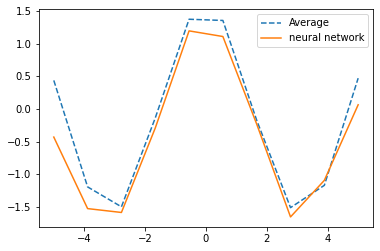

In [63]:
def plot_model_comparison_to_average(model, ds, model_name='neural network', K=10):
    '''Compare model to average.
    
    Computes mean of training sine waves actual `y` and compare to
    the model's prediction to a new sine wave, the intuition is that
    these two plots should be similar.
    '''
    sinu_generator = SinusoidGenerator(K=K)
    
    # calculate average prediction
    avg_pred = []
    for i, sinusoid_generator in enumerate(ds):
        x, y = sinusoid_generator.equally_spaced_samples()
        avg_pred.append(y)
    
    x, _ = sinu_generator.equally_spaced_samples()    
    avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0), '--')

    # calculate model prediction
    model_pred = model.forward(tf.convert_to_tensor(x))
    model_plot, = plt.plot(x, model_pred.numpy())
    
    # plot
    plt.legend([avg_plot, model_plot], ['Average', model_name])
    plt.show()
 
plot_model_comparison_to_average(neural_net, train_set)

### Transfer learning?

Here we try to use the trained neural network to initialize the weights for a model trained on new sine wave functions.

The new sine wave is treated as a new task. Our model was trained on a bunch of sine wave tasks and we're trying to use this previous knowledge to initialize the weights of the model for a new task.

In [89]:
def copy_model(model, x):
    '''Copy model weights to a new model.
    
    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    copied_model = SineModel()
    
    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.forward(tf.convert_to_tensor(x))
    
    copied_model.set_weights(model.get_weights())
    return copied_model
  

def eval_sine_test(model, optimizer, x, y, x_test, y_test, 
                   num_steps=(0, 1, 10)):
    '''Evaluate how the model fits to the curve training for `fits` steps.
    
    Args:
        model: Model evaluated.
        optimizer: Optimizer to be for training.
        x: Data used for training.
        y: Targets used for training.
        x_test: Data used for evaluation.
        y_test: Targets used for evaluation.
        num_steps: Number of steps to log.
    '''
    fit_res = []
    
    tensor_x_test, tensor_y_test = np_to_tensor((x_test, y_test))
    
    # If 0 in fits we log the loss before any training
    if 0 in num_steps:
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        fit_res.append((0, logits, loss))
        
    for step in range(1, np.max(num_steps) + 1):
        train_batch(x, y, model, optimizer)
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        if step in num_steps:
            fit_res.append(
                (
                    step,
                    logits,
                    loss
                )
            )
    return fit_res


def eval_sinewave_for_test(model, sinusoid_generator=None, 
                           num_steps=(0, 1, 10), lr=0.01, plot=True,
                           title=None):
    '''Evaluates how the sinewave addapts at dataset.
    
    The idea is to use the pretrained model as a weight initializer and
    try to fit the model on this new dataset.
    
    Args:
        model: Already trained model.
        sinusoid_generator: A sinusoidGenerator instance.
        num_steps: Number of training steps to be logged.
        lr: Learning rate used for training on the test data.
        plot: If plot is True than it plots how the curves are fitted along
            `num_steps`.
    
    Returns:
        The fit results. A list containing the loss, logits and step. For
        every step at `num_steps`.
    '''
    
    if sinusoid_generator is None:
        sinusoid_generator = SinusoidGenerator(K=10)
        
    # generate equally spaced samples for ploting
    x_test, y_test = sinusoid_generator.equally_spaced_samples(100)
    
    # batch used for training
    x, y = sinusoid_generator.batch()
    
    # copy model so we can use the same model multiple times
    copied_model = copy_model(model, x)
    
    # use SGD for this part of training as described in the paper
    optimizer = keras.optimizers.SGD(learning_rate=lr)
    
    # run training and log fit results
    fit_res = eval_sine_test(copied_model, optimizer, x, y, x_test, y_test, num_steps)
    
    # plot
    train, = plt.plot(x, y, '^')
    ground_truth, = plt.plot(x_test, y_test)
    plots = [train, ground_truth]
    legend = ['Training Points', 'True Function']
    for n, res, loss in fit_res:
        cur, = plt.plot(x_test, res[:, 0], '--')
        plots.append(cur)
        legend.append(f'After {n} Steps')
    plt.legend(plots, legend)
    plt.title(title)
    plt.ylim(-5, 5)
    plt.xlim(-6, 6)
    if plot:
        plt.show()
    
    return fit_res

### Try to use transfer learning for different sine waves

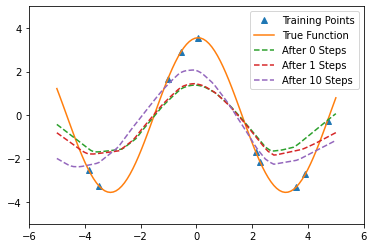

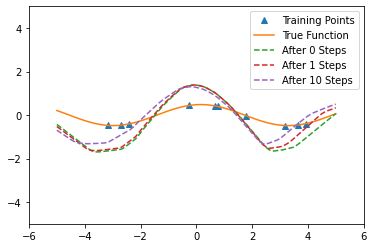

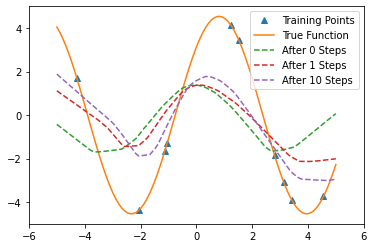

In [69]:
for index in np.random.randint(0, len(test_set), size=3):
    eval_sinewave_for_test(neural_net, test_set[index])

### MAML

![](https://cdn-images-1.medium.com/max/1600/1*_pgbRGIlmCRsYNBHl71mUA.png)

In [84]:
# Naive approach to training on different tasks,
def train_maml(model, dataset, epochs=1, batch_size=1, lr_inner=0.01, log_steps=1000):
    optimizer = keras.optimizers.Adam()

    # Step 2: instead of checking for convergence, we train for a number
    # of epochs
    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()

        # Step 3, 4
        for i, t in enumerate(random.sample(dataset, len(dataset))):
            x, y = np_to_tensor(t.batch())
            model.forward(x) # forward to initialize weights
            with tf.GradientTape() as test_tape:

              # Step 5
              with tf.GradientTape() as train_tape:
                train_loss, _ = compute_loss(model, x, y)

                # Step 6
                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                k = 0
                model_copy = copy_model(model, x)
                for j in range(len(model_copy.layers)):
                  model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
                                                            tf.multiply(lr_inner, gradients[k]))
                  model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
                                                          tf.multiply(lr_inner, gradients[k+1]))
                  k += 2
                # Step 8
                test_loss, logits = compute_loss(model_copy, x, y)
            # Step 8
            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            total_loss += test_loss 
            loss = total_loss / (i+1.0)
            losses.append(loss)

            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {}'.format(i, loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.show()

    return model

Step 1000: loss = 2.7355912954869686, Time to run 1000 steps = 24.75976538658142
Step 2000: loss = 2.413295361957831, Time to run 1000 steps = 24.84673833847046
Step 3000: loss = 2.1392771827708112, Time to run 1000 steps = 25.77430820465088
Step 4000: loss = 1.9408776628230244, Time to run 1000 steps = 26.31846857070923
Step 5000: loss = 1.7583662941112927, Time to run 1000 steps = 29.64919400215149
Step 6000: loss = 1.6019598781347455, Time to run 1000 steps = 28.69031810760498
Step 7000: loss = 1.4746015607385954, Time to run 1000 steps = 26.00701093673706
Step 8000: loss = 1.3677615734223885, Time to run 1000 steps = 26.090168476104736
Step 9000: loss = 1.2811301874805843, Time to run 1000 steps = 28.15934109687805
Step 10000: loss = 1.2032116803918922, Time to run 1000 steps = 26.946062803268433
Step 11000: loss = 1.1399274960061843, Time to run 1000 steps = 26.233527183532715
Step 12000: loss = 1.0849445702266125, Time to run 1000 steps = 26.20154619216919
Step 13000: loss = 1.03

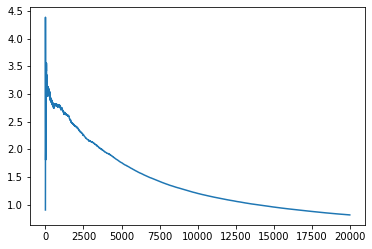

In [85]:
maml = SineModel()
train_maml(maml, train_set)

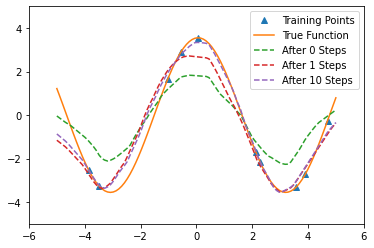

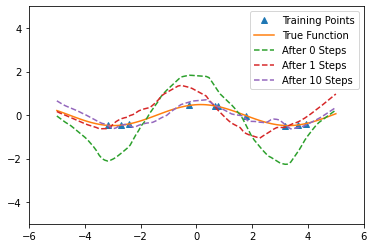

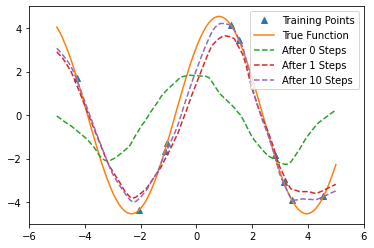

In [86]:
for index in np.random.randint(0, len(test_set), size=3):
    eval_sinewave_for_test(maml, test_set[index])

### MAML vs Regular Neural Network

In [90]:
def compare_maml_and_neural_net(maml, neural_net, sinusoid_generator, num_steps=list(range(10)),
                                intermediate_plot=True, marker='x', linestyle='--'):
    '''Compare the loss of a MAML model and a neural net.
    
    Fits the models for a new task (new sine wave) and then plot
    the loss of both models along `num_steps` interactions.
    
    Args:
        maml: An already trained MAML.
        neural_net: An already trained neural net.
        num_steps: Number of steps to be logged.
        intermediate_plot: If True plots intermediate plots from
            `eval_sinewave_for_test`.
        marker: Marker used for plotting.
        linestyle: Line style used for plotting.
    '''
    fit_maml = eval_sinewave_for_test(maml, sinusoid_generator, 
                                      plot=intermediate_plot, title="MAML")
    fit_neural_net = eval_sinewave_for_test(neural_net, sinusoid_generator, 
                                            plot=intermediate_plot,
                                            title="Neural Network")
    
    fit_res = {'MAML': fit_maml, 'Neural Net': fit_neural_net}
    
    legend = []
    for name in fit_res:
        x = []
        y = []
        for n, _, loss in fit_res[name]:
            x.append(n)
            y.append(loss)
        plt.title("MSE loss")
        plt.plot(x, y, marker=marker, linestyle=linestyle)
        plt.xticks(num_steps)
        legend.append(name)
    plt.legend(legend)
    plt.show()

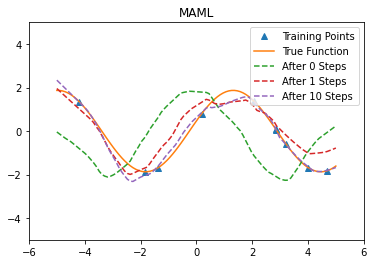

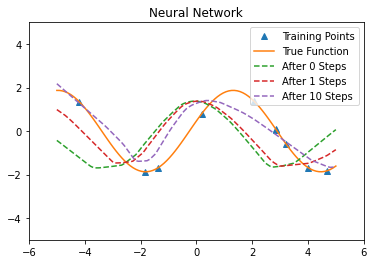

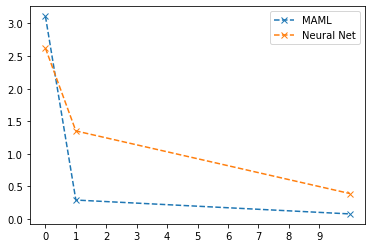

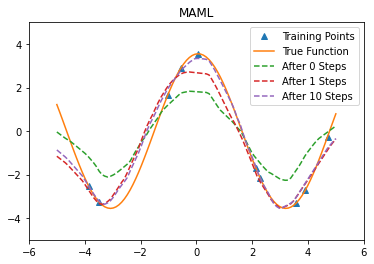

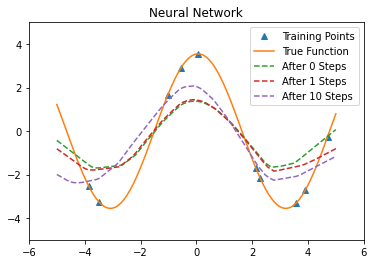

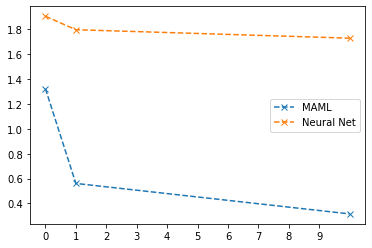

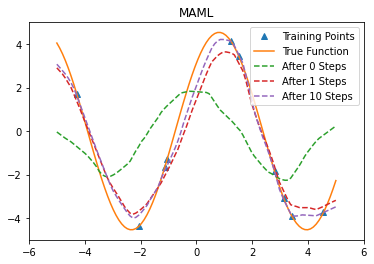

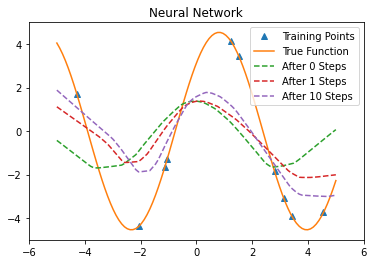

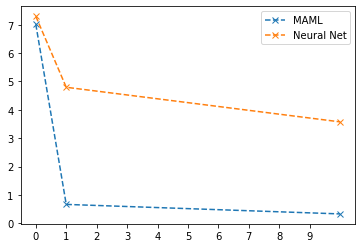

In [91]:
for index in np.random.randint(0, len(test_set), size=3):
    compare_maml_and_neural_net(maml, neural_net, test_set[index])